# head pose estimation 

###head pose estimation means detecting the position of a human head in the image. Particularly, it means detecting the head’s Euler angles – yaw, pitch and roll. They define the object’s rotation in a 3D environment. If you make the right prediction about these three, you’ll find out which direction the human head will be facing.

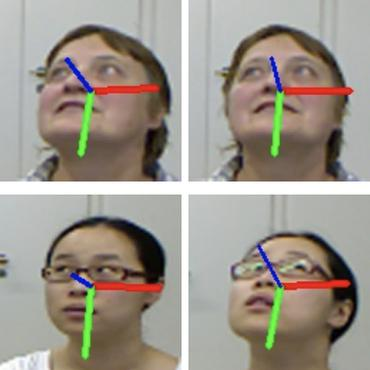

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


##Install MediaPipe

In [2]:
%%capture
!pip install mediapipe

##Import Libraries

In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow
from queue import Queue


In [4]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1Wx_1A_OPNZFY8R5lnVXFGbPqUL4oVpHH
  !unzip /content/AFLW2000-3D.zip

##Preparing Data for Training

In [5]:
# X_points, Y_points, labels and detected files which are the images thar MediaPipe was able to detect the face  
X_points = []
Y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]
print(X_points.shape)
print(Y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


##Preprocessing the data


In [6]:
# center 99
# max = 10
# min = 171
# centering the data arround the 99th point 
Center_X = X_points - X_points[:,99].reshape(-1,1)
Center_Y = Y_points - Y_points[:,99].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
X_171 = X_points[:,171]
X_10 = X_points[:,10]
Y_171 = Y_points[:,171]
Y_10 = Y_points[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

print(Final_X.shape)
print(Final_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


##Splitting the data for training the model and validation

In [9]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

##DataFrame for models

In [10]:
# initialize data of lists.
data = {'XGBRegressor': [''],
        'SVR': ['']}
 
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['pitch Train Error',
                               'pitch Validation Error',
                               'yaw Train Error',
                               'yaw Validation Error',
                               'roll Train Error',
                               'roll Validation Error'])
df['SVR']['pitch Validation Error']

''

##GridSearch for some models


In [11]:
xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
# grid search pitch
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_pitch = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_pitch.fit(X_train, y_train_pitch)
xg_winner_pitch = xg_gs_pitch.best_estimator_
print("Pitch Winner Model: ",xg_winner_pitch)
df['XGBRegressor']['pitch Train Error'] = mean_absolute_error(xg_winner_pitch.predict(X_train),y_train_pitch)
df['XGBRegressor']['pitch Validation Error'] = mean_absolute_error(xg_winner_pitch.predict(X_val),y_val_pitch)
print(40*"____")

# grid search yaw
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_yaw = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_yaw.fit(X_train, y_train_yaw)
xg_winner_yaw = xg_gs_yaw.best_estimator_
print("Yaw")
print("Yaw Winner Model: ",xg_winner_yaw)
df['XGBRegressor']['yaw Train Error'] = mean_absolute_error(xg_winner_yaw.predict(X_train),y_train_yaw)
df['XGBRegressor']['yaw Validation Error'] = mean_absolute_error(xg_winner_yaw.predict(X_val),y_val_yaw)
print(40*"____")

# grid search roll
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_roll = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_roll.fit(X_train, y_train_roll)
xg_winner_roll = xg_gs_roll.best_estimator_
print("Roll")
print("Roll Winner Model: ",xg_winner_roll)
df['XGBRegressor']['roll Train Error'] = mean_absolute_error(xg_winner_roll.predict(X_train),y_train_roll)
df['XGBRegressor']['roll Validation Error'] = mean_absolute_error(xg_winner_roll.predict(X_val),y_val_roll)
print(40*"____")

Pitch Winner Model:  XGBRegressor(learning_rate=0.8999999999999999, max_depth=1, n_estimators=13,
             verbosity=0)
________________________________________________________________________________________________________________________________________________________________
Yaw
Yaw Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=7, verbosity=0)
________________________________________________________________________________________________________________________________________________________________
Roll
Roll Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=1, n_estimators=9, verbosity=0)
________________________________________________________________________________________________________________________________________________________________


##GridSearch for SVR models


In [12]:
svr_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
# grid search pitch
svr = SVR()
svr_gs_pitch = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_pitch.fit(X_train, y_train_pitch)
svr_winner_pitch = svr_gs_pitch.best_estimator_
print('Pitch')
print("Pitch Winner Model: ",svr_winner_pitch)
df['SVR']['pitch Train Error']=mean_absolute_error(svr_winner_pitch.predict(X_train),y_train_pitch)
df['SVR']['pitch Validation Error']=mean_absolute_error(svr_winner_pitch.predict(X_val),y_val_pitch)
print(40*'____') 

# grid search yaw
svr = SVR()
svr_gs_yaw = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_yaw.fit(X_train, y_train_yaw)
svr_winner_yaw = svr_gs_yaw.best_estimator_
print('Yaw')
print("Yaw Winner Model: ",svr_winner_yaw)
df['SVR']['yaw Train Error']=mean_absolute_error(svr_winner_yaw.predict(X_train),y_train_yaw)
df['SVR']['yaw Validation Error']= mean_absolute_error(svr_winner_yaw.predict(X_val),y_val_yaw)
print(40*'____') 


# grid search roll
svr = SVR()
svr_gs_roll = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_roll.fit(X_train, y_train_roll)
svr_winner_roll = svr_gs_roll.best_estimator_
print('Yaw')
print("Yaw Winner Model: ",svr_winner_roll)
df['SVR']['roll Train Error']=mean_absolute_error(svr_winner_roll.predict(X_train),y_train_roll)
df['SVR']['roll Validation Error']= mean_absolute_error(svr_winner_roll.predict(X_val),y_val_roll)
print(40*'____')



Pitch
Pitch Winner Model:  SVR(C=100, kernel='poly')
________________________________________________________________________________________________________________________________________________________________
Yaw
Yaw Winner Model:  SVR(C=100, kernel='poly')
________________________________________________________________________________________________________________________________________________________________
Yaw
Yaw Winner Model:  SVR(C=10)
________________________________________________________________________________________________________________________________________________________________


In [13]:
#Comparison between models
df*100

,XGBRegressor,SVR
pitch Train Error,12.16173,9.066987
pitch Validation Error,15.801939,9.771672
yaw Train Error,5.42364,6.834032
yaw Validation Error,9.444333,7.244728
roll Train Error,10.835985,7.648555
roll Validation Error,15.336967,7.851114


##From the comparison above, it is clear that the SVR model is better

##Defining function for drawing the 3 axis


In [14]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

##Visualing Random image and drawing its points and axis

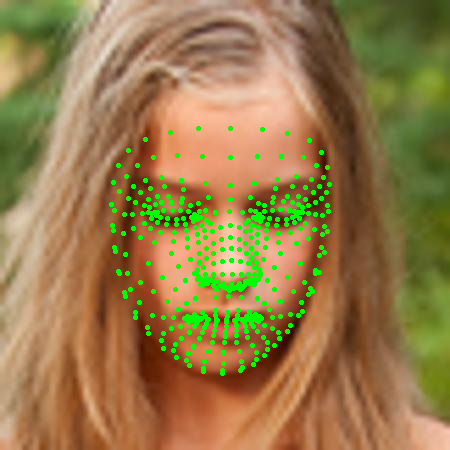

In [15]:
# choosing random image from the testing data
image_name = random.choice(file_test)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    cv2_imshow(frame)

##Drawing the axis from the true labels on the image

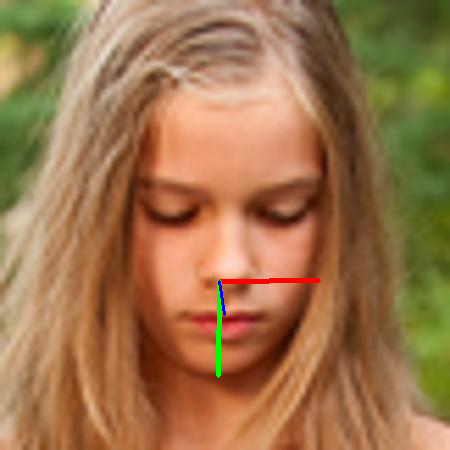

In [16]:
# reading the image
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2.destroyAllWindows()
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))

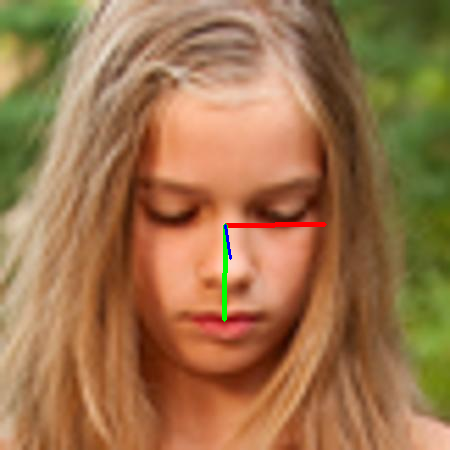

-0.056261074 -0.33822578 0.009401863


In [17]:
image = cv2.imread('/content/AFLW2000/'+image_name+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+image_name+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))
print(yaw, pitch, roll)

##Testing the model on the image

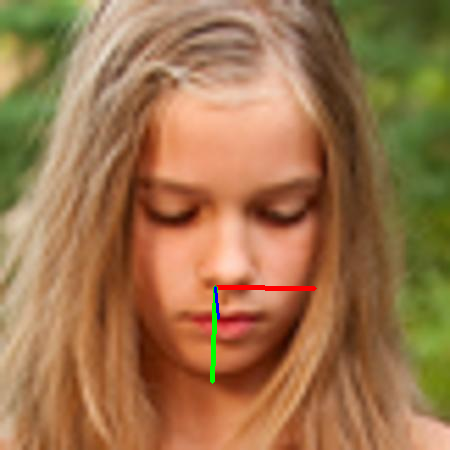

In [18]:
# choosing random image from the testing data
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        X_center = X - X[99]
        Y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = svr_winner_pitch.predict(points)
        pred_yaw = svr_winner_yaw.predict(points)
        pred_roll = svr_winner_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))



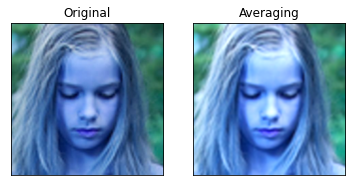

In [19]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
kernel = np.ones((5,5),np.float32)/20
dst = cv.filter2D(img,-1,kernel)
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

##Testing the model on a video by processing its frames and drawing the axis on them


In [20]:
# loading the test video
%%capture
!git clone https://github.com/AlaaAElshafei/Head-Pose-Estimation

In [21]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/content/Head-Pose-Estimation/test_video.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
img_array = []
size = 25
pitch_q = Queue(maxsize = size)
yaw_q = Queue(maxsize = size)
roll_q = Queue(maxsize = size)
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              X = []
              Y = []
              for j,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)

              X = np.array(X)
              Y = np.array(Y)
              # centering the data arround the point 99
              X_center = X - X[99]
              Y_center = Y - Y[99]
              d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
              X_norm = X_center/d
              Y_norm = Y_center/d
              X_norm = X_norm
              Y_norm = Y_norm
              points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
              # predicting the 3 angels to draw the axis on the image
              if (pitch_q.full()):
                pitch_q.get()
                yaw_q.get()
                roll_q.get()
              pred_pitch = svr_winner_pitch.predict(points)
              pitch_q.put(pred_pitch)
              pred_yaw = svr_winner_yaw.predict(points)
              yaw_q.put(pred_yaw)
              pred_roll = svr_winner_roll.predict(points)
              roll_q.put(pred_roll)

              pitch_l = list(pitch_q.queue)
              yaw_l = list(yaw_q.queue)
              roll_l = list(roll_q.queue)

              pitch_an =sum(pitch_l)/len(pitch_l)
              yaw_an = sum(yaw_l)/len(yaw_l)
              roll_an =  sum(roll_l)/len(roll_l)

              draw_axis(frame,pitch_an,yaw_an,roll_an,X[99],Y[99])
              #kernel = np.ones((5,5),np.float32)/30
              #frame1 = cv.filter2D(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]),-1,kernel)
              img_array.append(frame)
    else: 
        break

cap.release()  
cv2.destroyAllWindows()
print("Number of Detected Frames = ",len(img_array))

Number of Detected Frames =  623


In [22]:
img_array[11]

array([[[147, 153, 157],
        [147, 153, 157],
        [147, 153, 157],
        ...,
        [172, 175, 175],
        [172, 175, 175],
        [172, 175, 175]],

       [[149, 155, 159],
        [149, 155, 159],
        [147, 153, 157],
        ...,
        [172, 175, 175],
        [172, 175, 175],
        [172, 175, 175]],

       [[150, 156, 160],
        [150, 156, 160],
        [149, 155, 159],
        ...,
        [173, 176, 176],
        [173, 176, 176],
        [173, 176, 176]],

       ...,

       [[115,  98,  85],
        [113,  96,  83],
        [114,  97,  84],
        ...,
        [102,  86,  76],
        [110,  94,  86],
        [102,  86,  78]],

       [[109,  92,  79],
        [107,  90,  77],
        [113,  96,  83],
        ...,
        [107,  91,  83],
        [105,  89,  81],
        [ 94,  78,  70]],

       [[114,  97,  84],
        [109,  92,  79],
        [109,  92,  79],
        ...,
        [102,  86,  78],
        [ 99,  83,  75],
        [ 94,  78,  70]]

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# converting the frames to video
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [25]:
from google.colab import files
files.download('/content/out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>